In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

In [2]:
# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

In [3]:
data = r'data/arxiv_network_science_data.csv'

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)
df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

authors                                              title
0     Dustin Nguyen  Neural ODEs as a discovery tool to characteriz...
1     Yuan-Sen Ting  Neural ODEs as a discovery tool to characteriz...
2  Todd A. Thompson  Neural ODEs as a discovery tool to characteriz...
3   Sebastian Lopez  Neural ODEs as a discovery tool to characteriz...
4    Laura A. Lopez  Neural ODEs as a discovery tool to characteriz...

In [4]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, B.nodes)

In [6]:
print(G)

Graph with 91659 nodes and 387745 edges


In [7]:
# this is network science network without labels; takes forever; run and walk away if want to see

#draw_graph(G, node_size=1, show_names=False, edge_width=0.3)

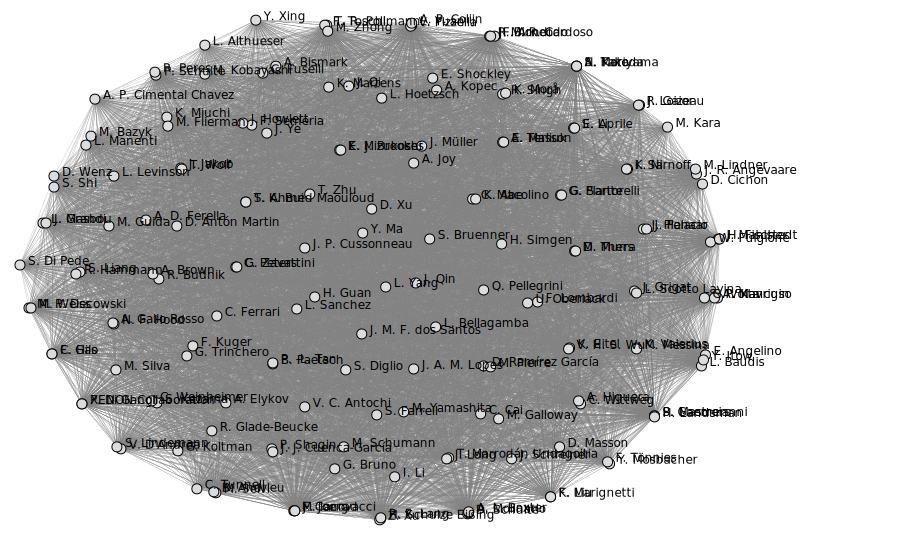

In [8]:
# this is the core of the network science network with labels; the largest cluster in the bipartite projection

draw_graph(nx.k_core(G, 160), node_size=5, font_size=12, show_names=True, edge_width=0.1)

In [9]:
nodes = list(nx.k_core(G, 160).nodes)
df[df['authors'].isin(nodes)]['title'].value_counts()

title
Detector signal characterization with a Bayesian network in XENONnT                                                               167
Tailoring Magnetism in Self-intercalated Cr1+δTe2 Epitaxial Films                                                                   1
MOA-2007-BLG-197: Exploring the brown dwarf desert                                                                                  1
Domain Wall Roughness in Stripe Phase BiFeO$_3$ Thin Films                                                                          1
Effect of Dilution on Spinodals and Pseudospinodals                                                                                 1
Imprinting nanoporous alumina patterns into the magneto-transport of oxide superconductors                                          1
Searching for prompt signatures of nearby core-collapse supernovae by a joint analysis of neutrino and gravitational-wave data      1
Thermal Transient Characterization of Packaged Thin Film

# Egocentric Network Analysis

As the above visualization shows, this is a complex network. For knowledge discovery, we should use Egocentric Network Analysis to "zoom in" on nodes of interest. Any node can be looked at, but I am going to programmatically do this, in this notebook, showing only the top twenty nodes, according to page rank.

# PageRank - Identify Nodes of Interest

In [10]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

page_rank
Mason A. Porter       0.000154
Wei Chen              0.000143
Shlomo Havlin         0.000127
Tao Zhou              0.000126
Yang Liu              0.000125
Guanrong Chen         0.000122
H. Vincent Poor       0.000121
Walid Saad            0.000119
Danielle S. Bassett   0.000117
Dusit Niyato          0.000113

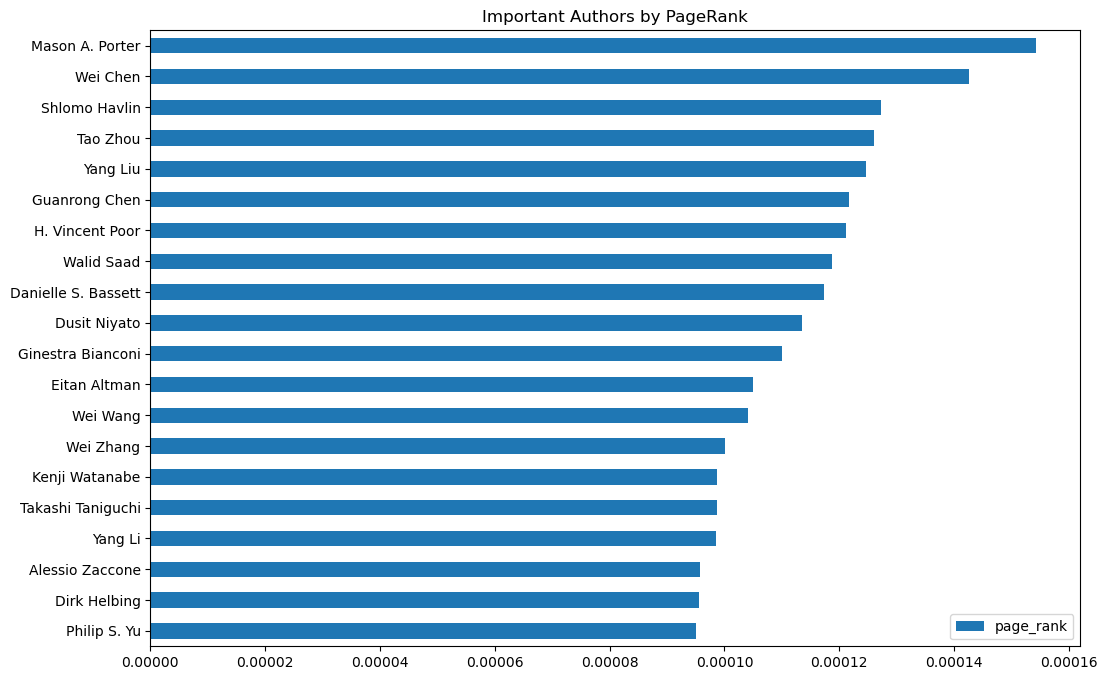

In [11]:
title = 'Important Authors by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

# Egocentric Network Analysis
Next, let's look at the Ego Graphs for each of the top ten characters found by PageRank. Before visualizing and inspecting the Ego Graphs, let's create a Python list so that we can more easily look through them without explicitely typing their names.

In [12]:
top_nodes = pr_df.head(20).index.values

In [13]:
top_nodes[0]

'Mason A. Porter'

Now we are all set to start looking through them, in order of importance.

## Top Node Ego Networks
Unlike last time, I am not going to drop the center node or write about findings. This is purely discovery. Remember two things:
- The center node is known as the 'ego' node. It is the node being looked up.
- The other nodes are known as 'alter' nodes. They are connected to the ego node, and sometimes with each other.

Pay close attention to the alter nodes that link to other alter nodes. These are interesting relationships, and you can see subcommunities in the ego network. Think about what you are seeing. What does this tell you?

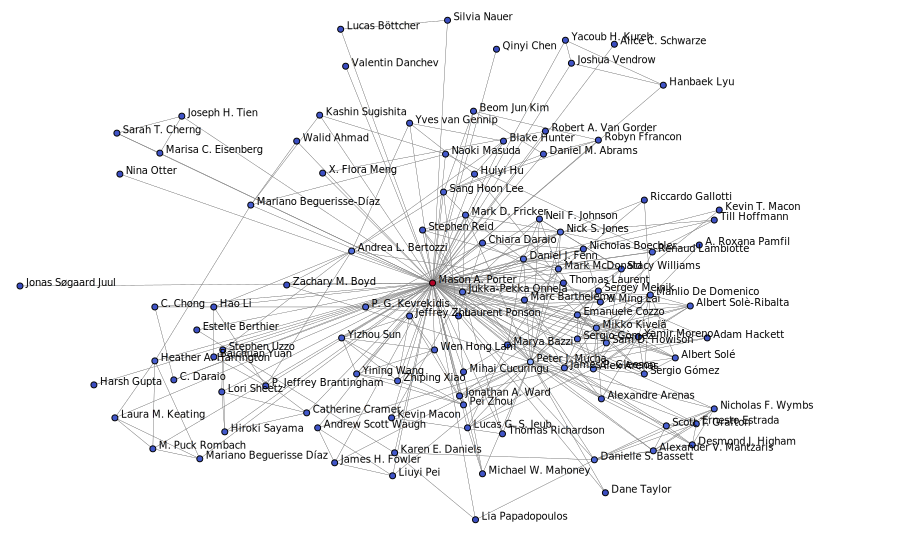

In [14]:
ego = top_nodes[0]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

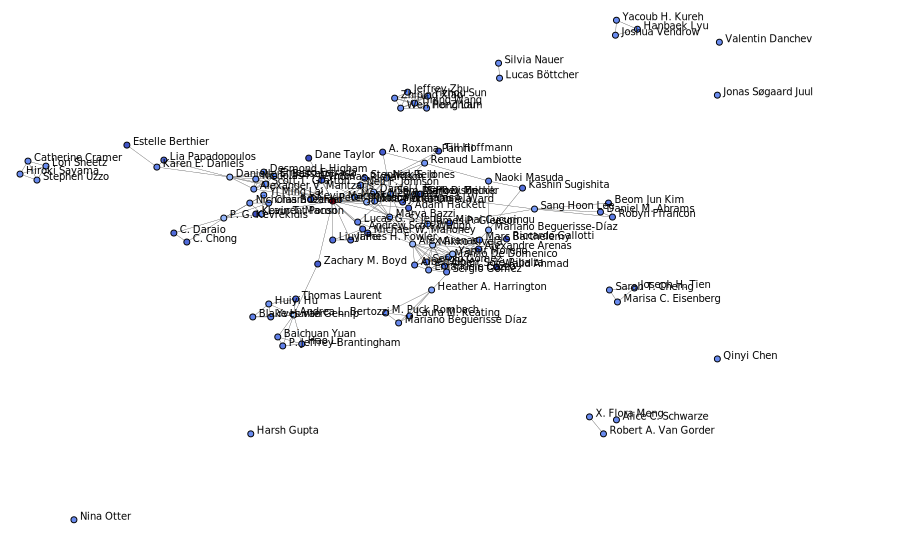

In [15]:
ego = top_nodes[0]

G_ego = nx.ego_graph(G, ego, center=False)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

In [16]:
# you can look at what articles the author was part of this way, going from networks to NLP

sorted(df[df['authors']==ego]['title'])

['A Framework for the Construction of Generative Models for Mesoscale Structure in Multilayer Networks',
 'A Local Perspective on Community Structure in Multilayer Networks',
 'A Method Based on Total Variation for Network Modularity Optimization using the MBO Scheme',
 'A unified framework for equivalences in social networks',
 'Accuracy of Mean-Field Theory for Dynamics on Real-World Networks',
 'Communities in Networks',
 'Community Structure in Time-Dependent, Multiscale, and Multiplex Networks',
 'Community Structure in the United Nations General Assembly',
 'Community detection in temporal multilayer networks, with an application to correlation networks',
 'Complex networks with complex weights',
 'Cross-Linked Structure of Network Evolution',
 'Density-based and transport-based core-periphery structures in networks',
 'Detecting Political Biases of Named Entities and Hashtags on Twitter',
 'Dynamic Network Centrality Summarizes Learning in the Human Brain',
 'Dynamical Clusterin

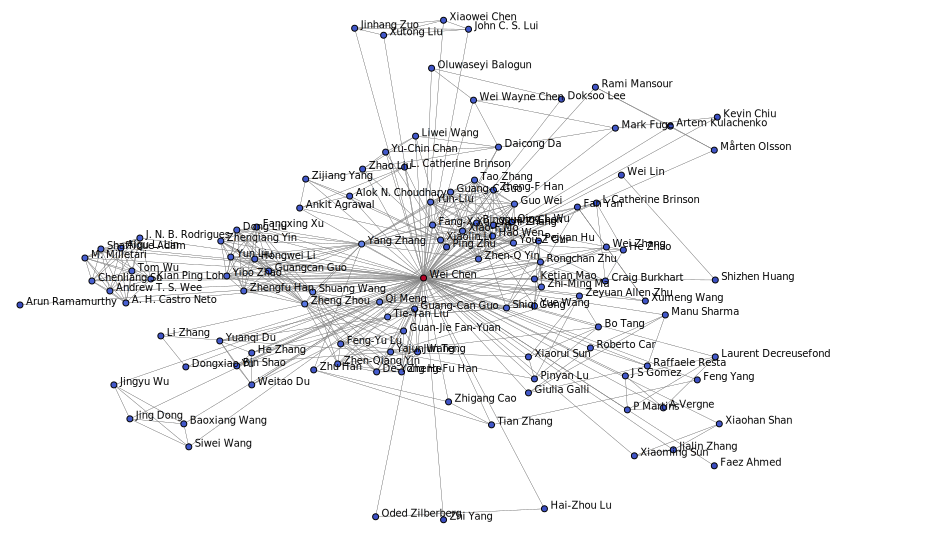

In [17]:
ego = top_nodes[1]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

In [18]:
# you can look at what articles the author was part of this way, going from networks to NLP

sorted(df[df['authors']==ego]['title'])

['A Game Theoretic Model for the Formation of Navigable Small-World Networks --- the Tradeoff between Distance and Reciprocity',
 'A Novel VSWR-Protected and Controllable CMOS Class E Power Amplifier for Bluetooth Applications',
 'A Transfer Learning Approach for Microstructure Reconstruction and Structure-property Predictions',
 'Airfoil Design Parameterization and Optimization using Bézier Generative Adversarial Networks',
 'Coalitional Game Theoretic Approach for Cooperative Transmission in Vehicular Networks',
 'Coreness of Cooperative Games with Truncated Submodular Profit Functions',
 'Cournot-Nash Equilibria for Bandwidth Allocation under Base-Station Cooperation',
 'Data offloading in mobile edge computing: A coalitional game based pricing approach',
 'Deep Generative Model for Efficient 3D Airfoil Parameterization and Generation',
 'Enhancing Data-driven Multiscale Topology Optimization with Generalized De-homogenization',
 'Field Experiment on a Robust Hierarchical Metropolit

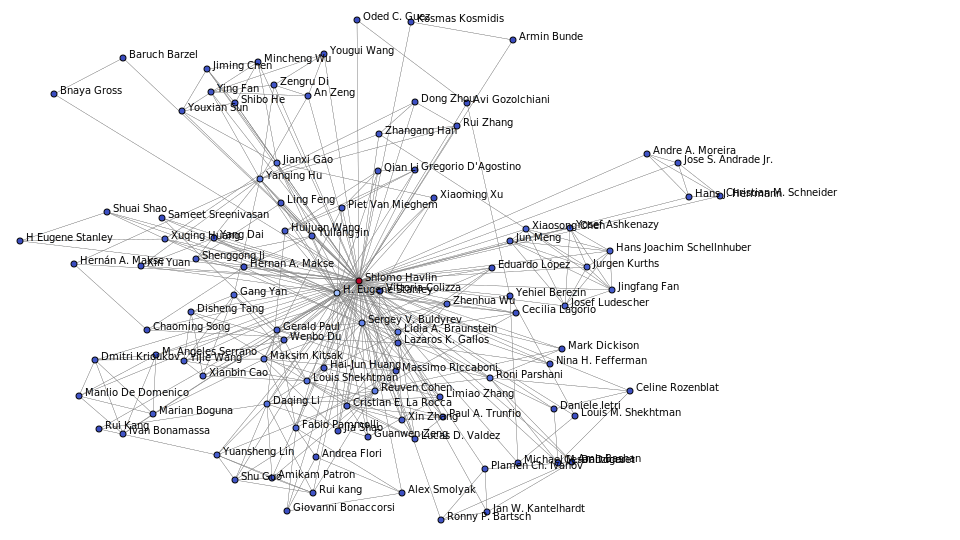

In [19]:
ego = top_nodes[2]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

In [20]:
# you can look at what articles the author was part of this way, going from networks to NLP

sorted(df[df['authors']==ego]['title'])

['$k$-core percolation on complex networks: Comparing random, localized and targeted attacks',
 'Betweenness Centrality of Fractal and Non-Fractal Scale-Free Model Networks and Tests on Real Networks',
 'Cascade of failures in coupled network systems with multiple support-dependent relations',
 'Cascading Failures in Complex Networks',
 'Catastrophic cascade of failures in interdependent networks',
 'Conditions for viral influence spreading through multiplex correlated social networks',
 'Current Flow in Random Resistor Networks: The Role of Percolation in Weak and Strong Disorder',
 'Dense network motifs enhance dynamical stability',
 'Design of endurable networks in the presence of aging',
 'Discrimination universally determines reconstruction of multiplex networks',
 'Dynamic networks and directed percolation',
 'Effect of the Interconnected Network Structure on the Epidemic Threshold',
 'Effects of mobility restrictions during COVID19 in Italy',
 'Epidemic spreading and control str

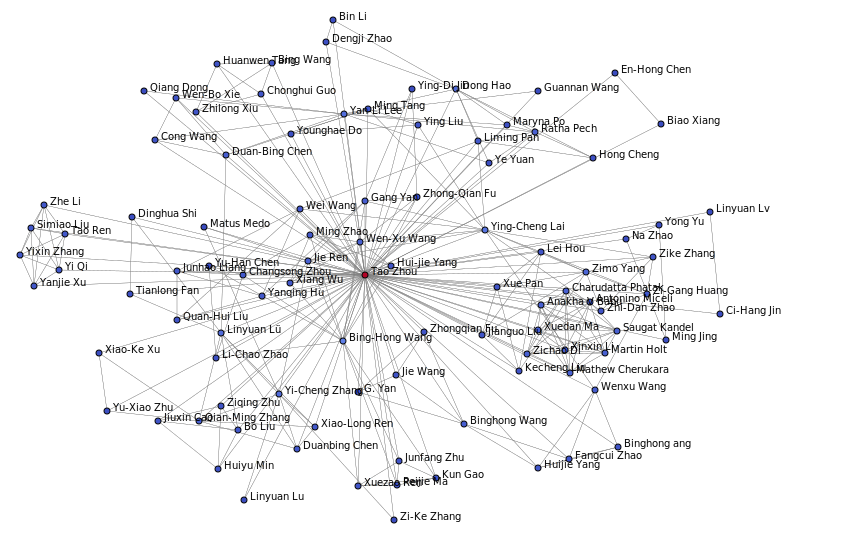

In [21]:
ego = top_nodes[3]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

In [22]:
# you can look at what articles the author was part of this way, going from networks to NLP

sorted(df[df['authors']==ego]['title'])

['A generalized method toward drug-target interaction prediction via low-rank matrix projection',
 'Characterizing cycle structure in complex networks',
 'Coevolution spreading in complex networks',
 'Collaborative Filtering Approach to Link Prediction',
 'Core-like groups result in invalidation of identifying super-spreader by k-shell decomposition',
 'Customer Sharing in Economic Networks with Costs',
 'Demonstration of an AI-driven workflow for autonomous high-resolution scanning microscopy',
 'Detecting network communities via greedy expanding based on local superiority index',
 'Discriminating abilities of threshold-free evaluation metrics in link prediction',
 'Effective and Efficient Similarity Index for Link Prediction of Complex Networks',
 'Emergence of scaling in human-interest dynamics',
 'Epidemic dynamics on complex networks',
 'Epidemic spread in weighted networks',
 'Experimental analyses on 2-hop-based and 3-hop-based link prediction algorithms',
 'Finding Community St

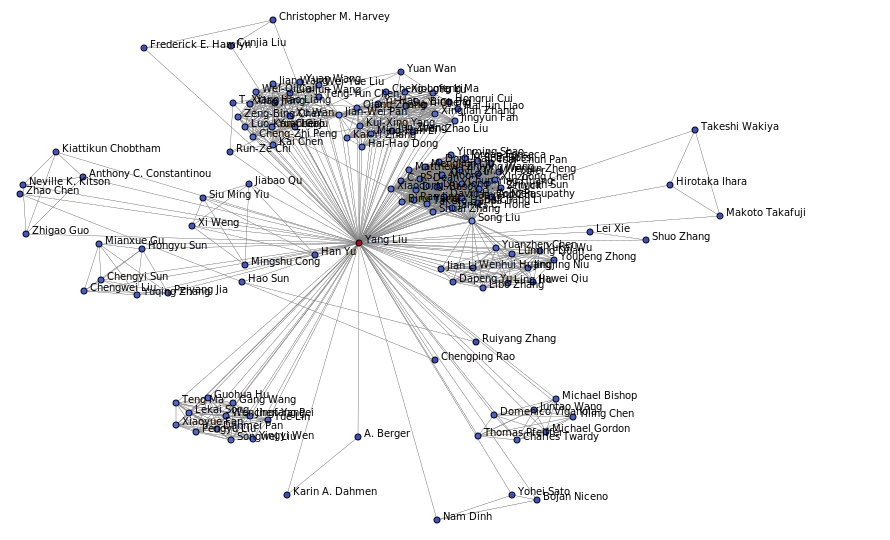

In [23]:
ego = top_nodes[4]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

In [24]:
# you can look at what articles the author was part of this way, going from networks to NLP

sorted(df[df['authors']==ego]['title'])

['A VCG-based Fair Incentive Mechanism for Federated Learning',
 'A survey of Bayesian Network structure learning',
 'Bayesian estimation and reconstruction of marine surface contaminant dispersion',
 'Cargo Ecosystem Dependency-Vulnerability Knowledge Graph Construction and Vulnerability Propagation Study',
 'Conduction modulation of solution-processed two-dimensional materials',
 'Data-driven modeling for boiling heat transfer: using deep neural networks and high-fidelity simulation results',
 'Deterministic quantum teleportation between distant superconducting chips',
 'Device-Independent-Quantum-Randomness-Enhanced Zero-Knowledge Proof',
 'Efficient and Accurate Physics-aware Multiplex Graph Neural Networks for 3D Small Molecules and Macromolecule Complexes',
 'Metropolitan all-pass and inter-city quantum communication network',
 'Physics informed deep learning for computational elastodynamics without labeled data',
 'Physics-Informed Multi-LSTM Networks for Metamodeling of Nonline

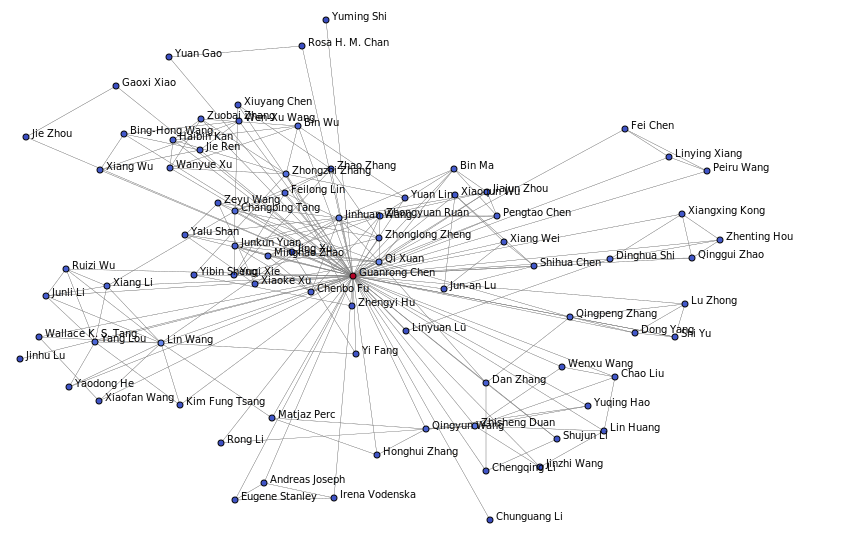

In [25]:
ego = top_nodes[5]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

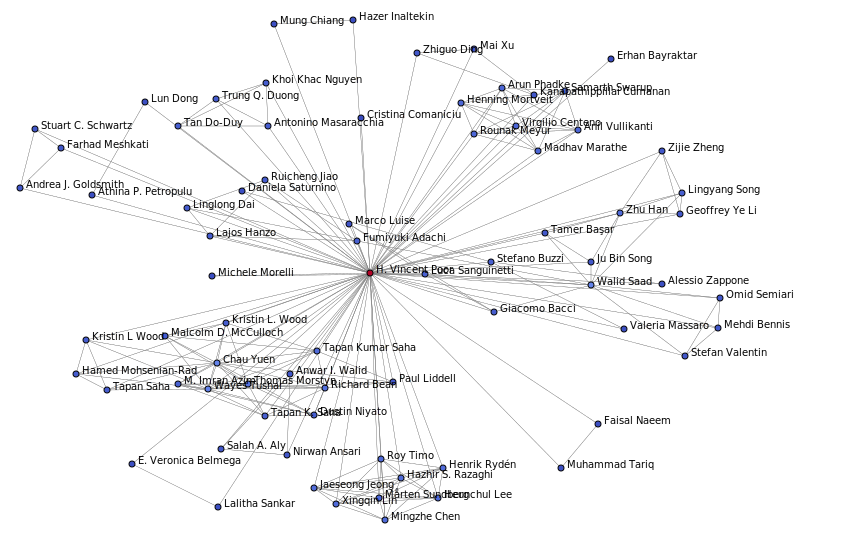

In [26]:
ego = top_nodes[6]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

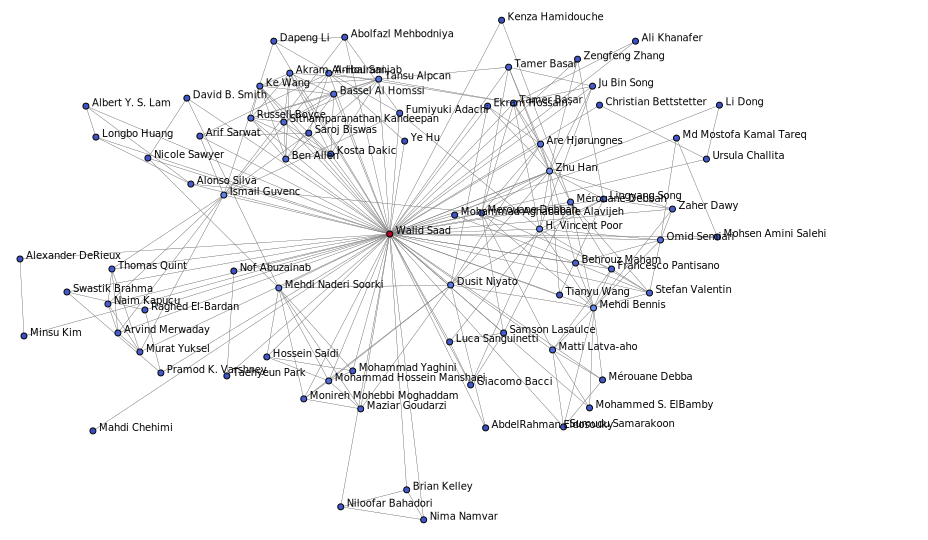

In [27]:
ego = top_nodes[7]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

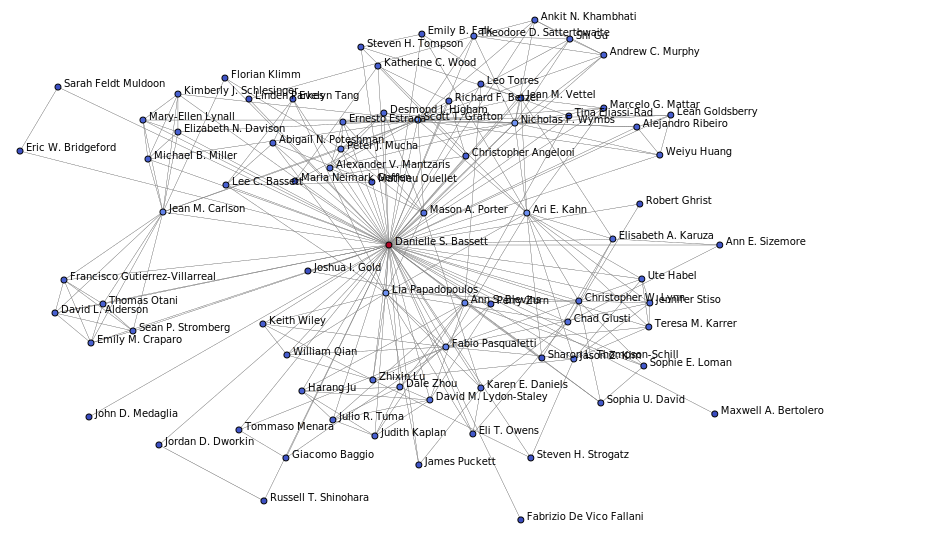

In [28]:
ego = top_nodes[8]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

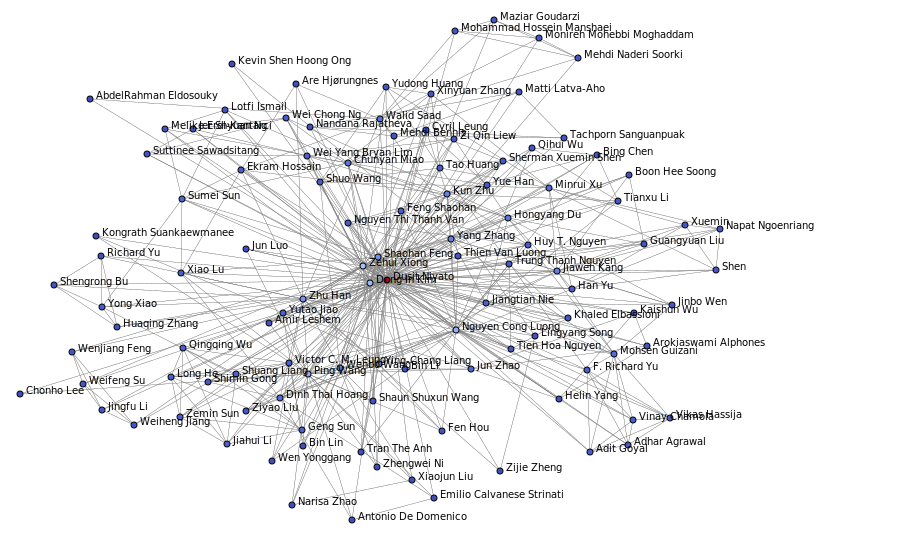

In [29]:
ego = top_nodes[9]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

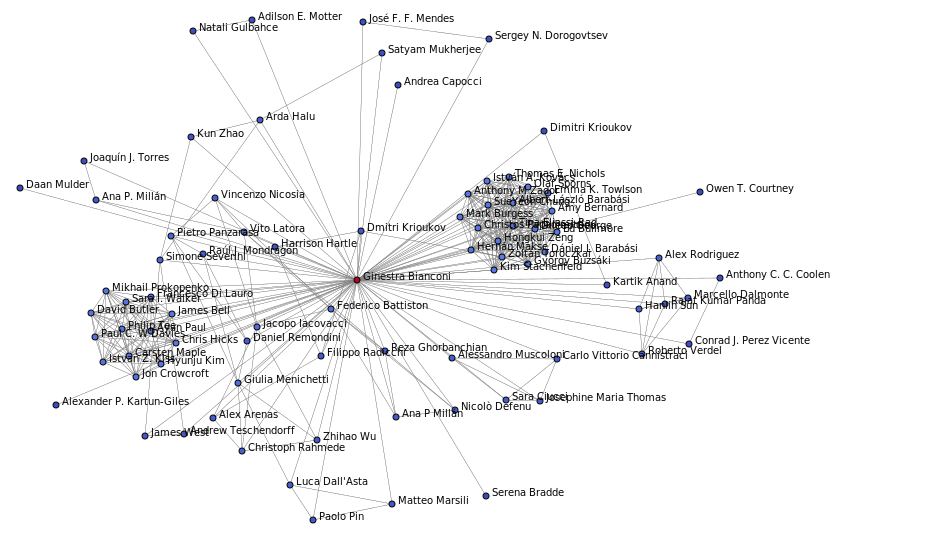

In [30]:
ego = top_nodes[10]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

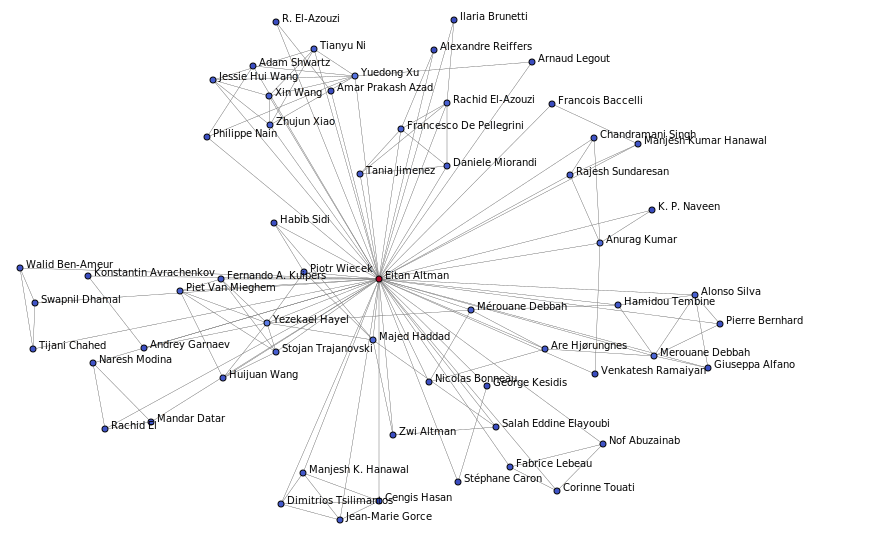

In [31]:
ego = top_nodes[11]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

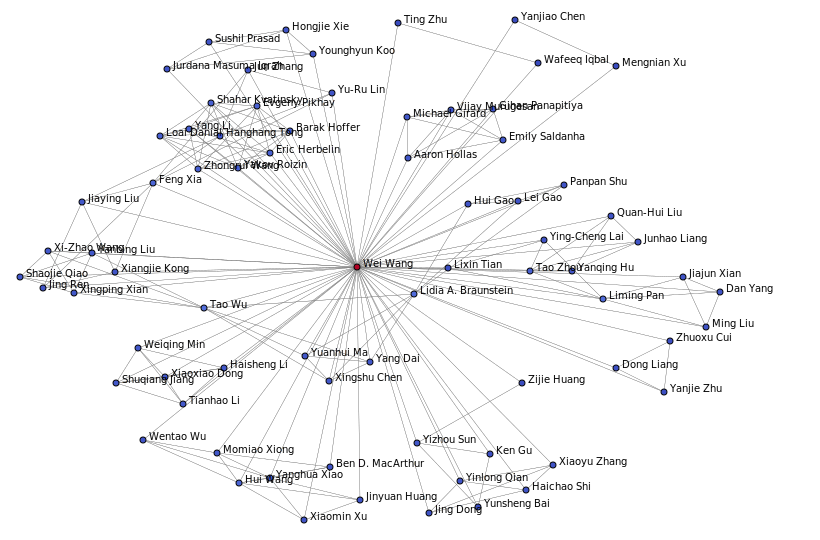

In [32]:
ego = top_nodes[12]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

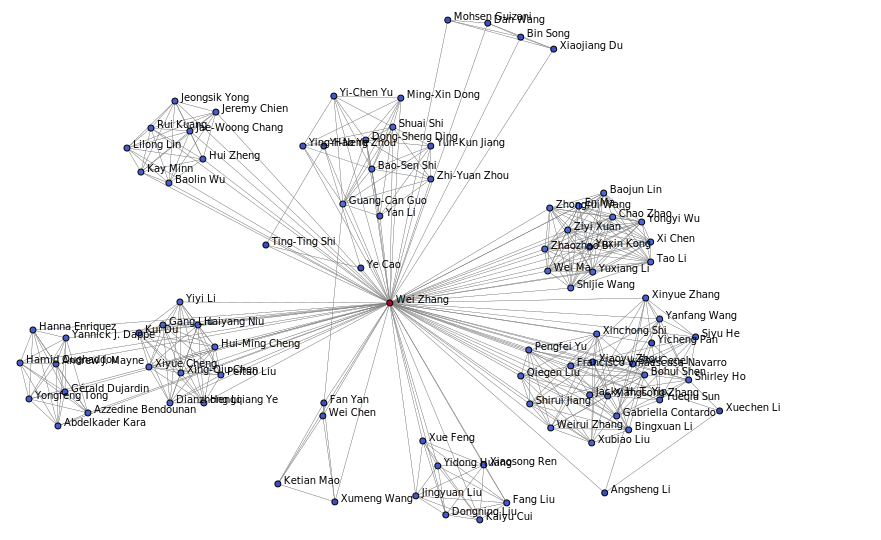

In [33]:
ego = top_nodes[13]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

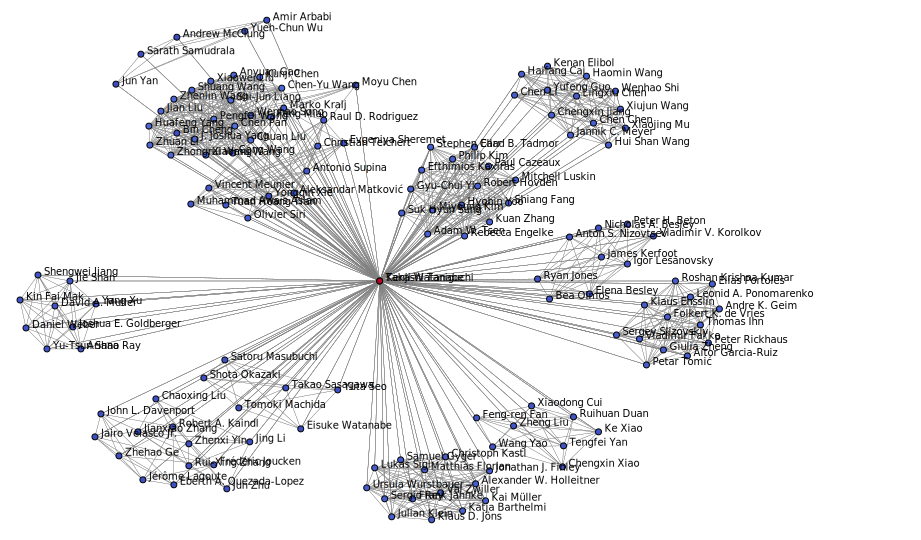

In [34]:
ego = top_nodes[14]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

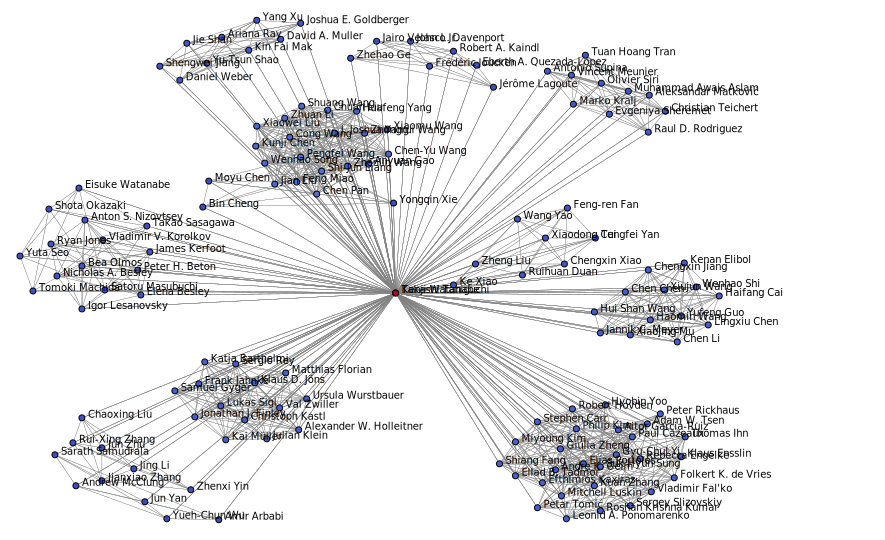

In [35]:
ego = top_nodes[15]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

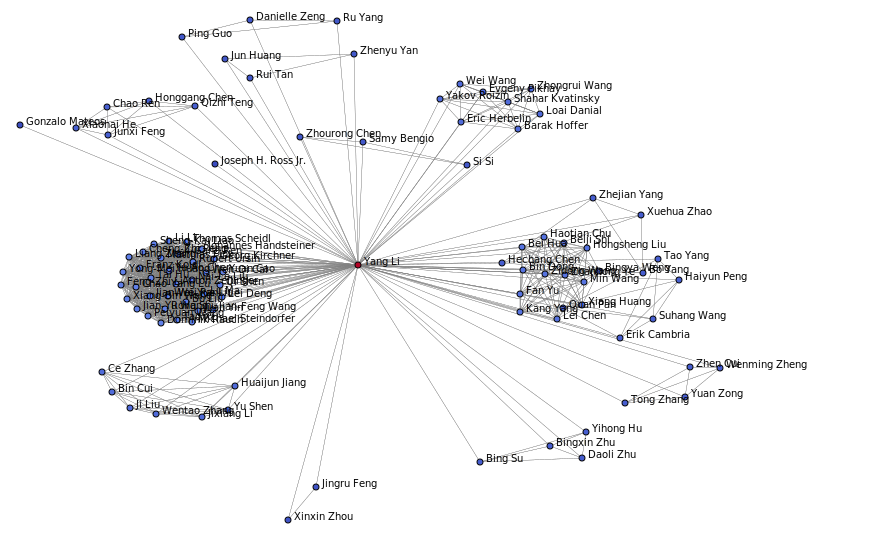

In [36]:
ego = top_nodes[16]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

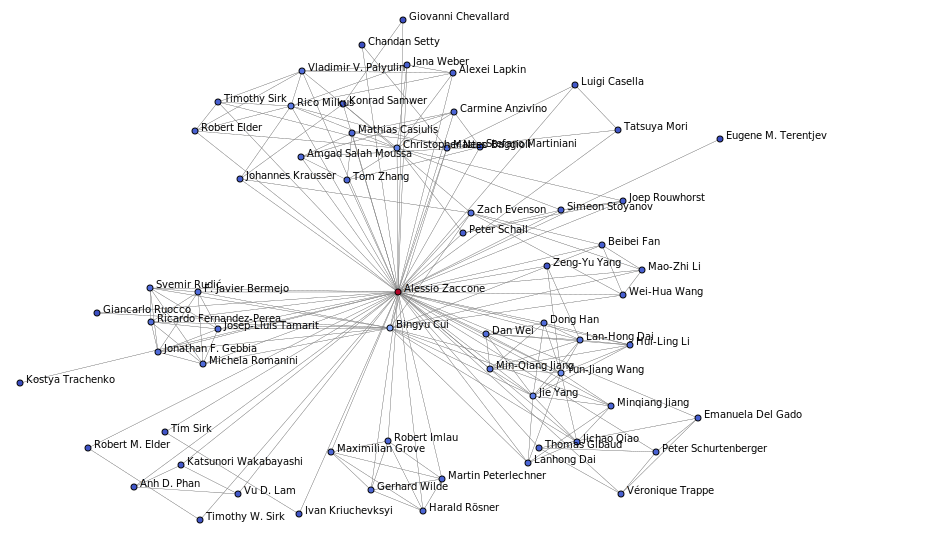

In [37]:
ego = top_nodes[17]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

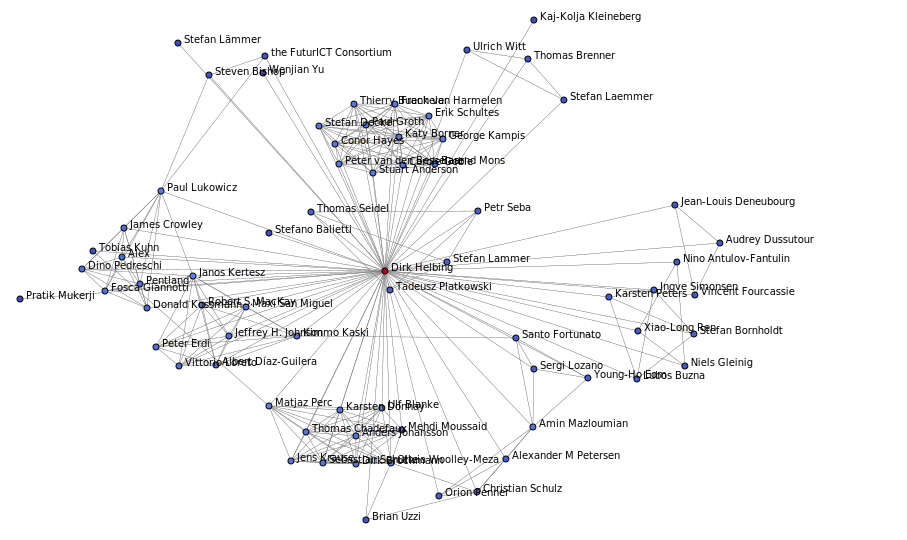

In [38]:
ego = top_nodes[18]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

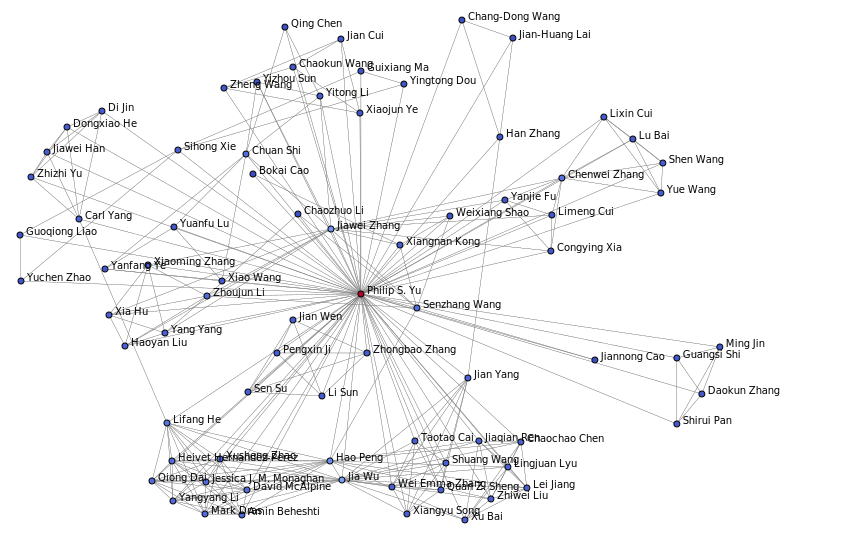

In [39]:
ego = top_nodes[19]

G_ego = nx.ego_graph(G, ego)

draw_graph(G_ego, show_names=True, node_size=3, edge_width=0.3)

# This is the Beginning

This is just the beginning of this network exploration. There are communities and connected components that should be explored. There are articles to read and authors to learn about and follow. We will certainly do more with these networks.